## Workshop Audio Classification with Deep Learning 

### HS Düsseldorf, 01.06.2022 


This is a workshop from Fabian Seipel and Corvin Jaedicke (TU Berlin, Audiotechnolgy and [ai|coustics](https://ai-coustics.com)). 
We will showcase a small example how to train a Deep Learning classifier on environmental sounds like siren, street_music, children_playing, dog_bark. These audio samples are a subset from the UrbanSound8k dataset (https://urbansounddataset.weebly.com/urbansound8k.html).

## Overview

1. Download and explore the TinyUrbanSound8k dataset
2. Spectrogram representations of audio
3. Preprocessing and TF Datsets
4. Model training
5. Evaluation of results


---

## Machine Learning x Audio

**Active research fields:**
- Music Information Retrieval
- Music Recommender Systems
- Music Generation (Midi and Waveform)
- Automatic Music Transcription
- Blind source separation
- Audio Event Detection
- Speech Enhancement
- Speech-to-text/Text-to-Speech
- Voice Cloning/Voice Synthesis


## Examples of Machine Learning Audio projects


**Music Generation:**
- Generating Piano Music: https://magenta.tensorflow.org/piano-transformer
- Magenta Tone Transfer: https://sites.research.google/tonetransfer
- Jukebox: https://openai.com/blog/jukebox/
- Lofi metal generation (GAN): https://www.youtube.com/watch?v=MwtVkPKx3RA
- Song generation (Autoencoder): https://www.youtube.com/watch?v=UWxfnNXlVy8

**Automatic Music Transcription:**
- Magenta Onset and Frames: https://goo.gl/magenta/piano-scribe, https://magenta.tensorflow.org/onsets-frames

**Blind source separation:**
- https://github.com/bytedance/music_source_separation (https://www.youtube.com/watch?v=WH4m5HYzHsg)

**Audio Event Detection:**
- Domestic AED: https://www.gierad.com/projects/listenlearner-automatic-class-discovery-and-one-shot-interactions-for-acoustic-activity-recognition/
- SoNYC: https://wp.nyu.edu/sonyc/
- Bird sound classification: https://www.kaggle.com/c/birdsong-recognition
- Rainforest Connection Species Audio Detection: https://www.kaggle.com/c/rfcx-species-audio-detection
- Whale detection challenge: https://www.kaggle.com/c/whale-detection-challenge/data

**Speech Enhancement:**
- VoiceFixer: https://haoheliu.github.io/demopage-voicefixer/

**Voice Cloning:**
- Real-Time Voice Cloning: https://github.com/CorentinJ/Real-Time-Voice-Cloning

**Text-to-speech:**
- CoquiTTS: https://github.com/coqui-ai/tts



---

## Colab preparations

If you want to use this notebook in colab, then execute the following steps. They are not necessary for usage in a local jupyter notebook or lab: 

1. Go to https://colab.research.google.com/
2. Clone the workshop repo: `git clone https://gitlab.com/ai-coustics-public/workshops/workshop-hs-duesseldorf.git`
3. Change runtime to GPU
4. Tools -> Command palette -> Expand all sections 

---

### Clone repository

In [1]:
! git clone https://gitlab.com/ai-coustics-public/workshops/workshop-hs-duesseldorf.git

Cloning into 'workshop-hs-duesseldorf'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [2]:
%cd workshop-hs-duesseldorf

/content/workshop-hs-duesseldorf


## Install

In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 7.9 MB/s 


---

## 0. Imports

In [4]:
# standard libraries
import sys
import os
import glob
import tqdm
import json
import itertools
from pathlib import Path

# external libraries
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as pd

import tensorflow as tf
from tensorflow import keras

import soundfile as sf
import librosa
from librosa import display


---

## 1. Download and explore the TinyUrbanSound8k dataset

In [5]:
# download the dataset using this neat keras function
download_link = 'https://gitlab.com/ai-coustics-public/workshops/workshop-datasets/-/raw/main/TinyUrbanSound8k.tar.gz'
filepath = keras.utils.get_file(Path('./_data/TinyUrbanSound8k.tar.gz').resolve(),
                                download_link,
                                cache_subdir=Path('./_data/').resolve(),
                                extract=True,
                                untar=True)

129335296/129321767 [==============================] - 2s 0us/step


In [6]:
# see the classes 
folders = glob.glob('_data/TinyUrbanSound8k/*/*/')
folders

['_data/TinyUrbanSound8k/test/street_music/',
 '_data/TinyUrbanSound8k/test/children_playing/',
 '_data/TinyUrbanSound8k/test/dog_bark/',
 '_data/TinyUrbanSound8k/test/siren/',
 '_data/TinyUrbanSound8k/train/street_music/',
 '_data/TinyUrbanSound8k/train/children_playing/',
 '_data/TinyUrbanSound8k/train/dog_bark/',
 '_data/TinyUrbanSound8k/train/siren/']

Show unique labels:

In [7]:
classes = sorted(set([Path(f).parts[-1] for f in folders]))
classes

['children_playing', 'dog_bark', 'siren', 'street_music']

Let's have a look at some random samples:

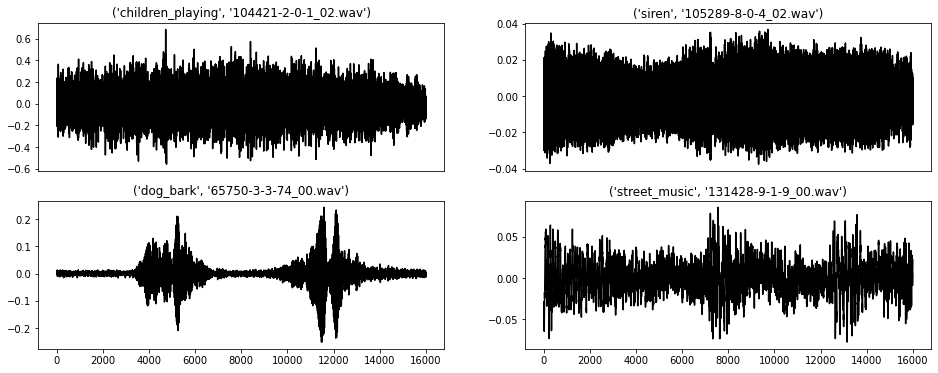

In [8]:
# get all wav files
fps = glob.glob('_data/TinyUrbanSound8k/**/*.wav', recursive=True)
fps_random = []
np.random.seed(9)

# setup subplot 
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, sr=None)
        ax[r][c].plot(audio, c='k')
        ax[r][c].set_title(Path(fp_random).parts[-2:])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)

In [9]:
# listen to the audio samples
for fp in fps_random:
    print(fp)
    pd.display(pd.Audio(fp))

_data/TinyUrbanSound8k/test/children_playing/104421-2-0-1_02.wav


_data/TinyUrbanSound8k/train/siren/105289-8-0-4_02.wav


_data/TinyUrbanSound8k/test/dog_bark/65750-3-3-74_00.wav


_data/TinyUrbanSound8k/train/street_music/131428-9-1-9_00.wav


---

## 2. Spectrogram representations

Most digital audio signals are representing continuous air pressure signals, captured by transducers such as microphones. The analog to digital conversion both includes a quantization in time and amplitude. This transformation, called pulse code modulation, stores a signal with a defined sampling frequency and bit depth in uncompressed formats like WAVE. These one-dimensional representations contain only few information compared to their storage size. Most MIR tasks, especially for deep learning, involve the transformation of raw wave forms to two-dimensional time-frequency representations.

### 2.1. Short time fourier transform (STFT)

The most common spectrogram representation is the **Short Time Fourier Transform** (STFT) which indicates the time-varying energy across different frequency bands. STFTs are typically calculated for short periods of time, so called frames or windows of length N, to obtain the magnitude and phase information per frequency bin k for a certain time frame:

$$ X(k) = \sum_{n=0}^{N-1} w(n) \ x(n) \ e^{−j2πkn/N} $$

### 2.2. Mel scale

In order to adapt this representation to the human perception of pitch, the linear STFT bands can be post-precessed to obtain other scales such as the mel scale. Using a bandpass filterbank of M bands, the frequency f can be mapped to the corresponding mel band m:

$$ m(f) = 2595 \ {log}_{10} \ (1 + \frac{f}{700}) $$

The mel scale represents **perceptually equal pitch distances** according to human listeners. Underneath figure displays the mapping from Hertz to mel scale as well as a **triangular filter bank** for a spectrum conversion to 8 mel bands.

### 2.3. Calculating spectrograms

Several python libraries offer **STFT and Melspectrogram functions**, for example librosa. The mel spectrogram reduces the feature dimensionality (size of the spectrogram) by a factor defined by the ratio of fft bins to mel bins, and at the same time preserving most of the spectrogram information.  

Audio shape: (16000,)
Melspec shape: (64, 63)
Total data points in mel-spectrogram: 4032
Total data points in audio waveform: 16000
-> Data Reduction by factor: 3.9682539682539684



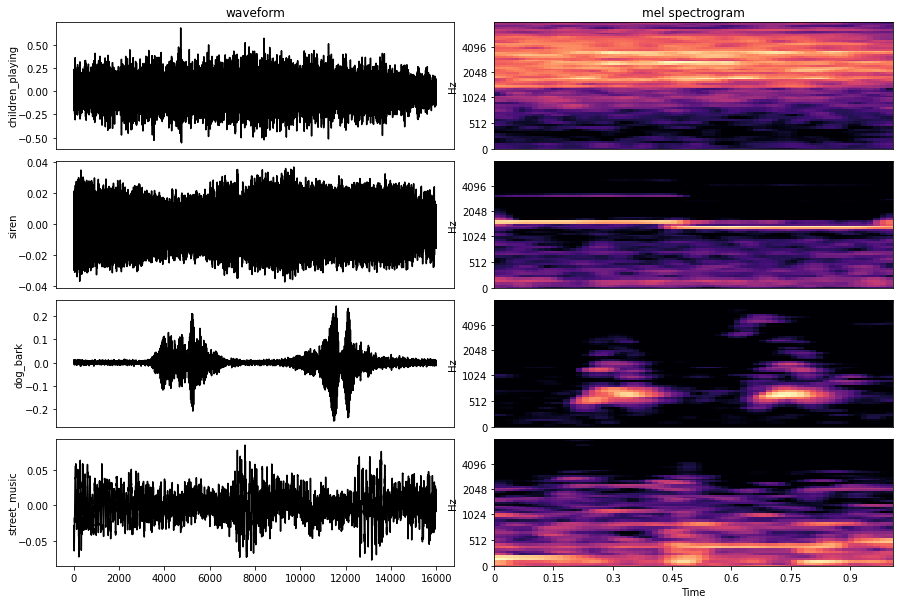

In [10]:
# setup subplot 
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# plot some audio waveforms
for i, fp_random in enumerate(fps_random):
    audio, sr = librosa.core.load(fp_random, sr=None)
    
    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio, n_fft=2048, hop_length=256, win_length=2048, n_mels=64, fmax=int(sr/2))
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # plot with librosa
    ax[i][0].plot(audio, c='k')
    librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=sr, hop_length=256, ax=ax[i][1])
    
    # adjustments
    ax[i][0].set_ylabel(Path(fp_random).parts[-2], rotation=90, labelpad=0)
    
    # settings for all axises but bottom ones
    if not i == len(fps_random) - 1:
        ax[i][0].set_xticks([]), ax[i][1].set_xticks([])
        ax[i][0].set_xlabel(''), ax[i][1].set_xlabel('')
    
    # settings for upper axises
    if i == 0:
        ax[i][0].set_title('waveform')
        ax[i][1].set_title('mel spectrogram')   

# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.1, wspace=0.1)

print('Audio shape: %s' % (str(audio.shape)))
print('Melspec shape: %s' % (str(melspec.shape)))
print(f'Total data points in mel-spectrogram: {melspec.shape[0]*melspec.shape[1]}')
print(f'Total data points in audio waveform: {audio.shape[0]}')
print(f'-> Data Reduction by factor: {(audio.shape[0]) / (melspec.shape[0]*melspec.shape[1])}')
print()

---

## 3. Preprocessing and TF Dataset


For the spectrograms calculation we need to define some parameters. Since we need those several times in the follwing functions and script, a best practice is to **collect all these parameters in a dictionary** and save it besides the features, so we have a reference when we reload the features for training.

In [11]:
# best-practice: write down your preprocessing config in a dictonary
config = {'sr': 16000, 
          'audio_length': 1,
          'mono': True,
          'n_mels': 64,
          'n_fft': 2048,
          'hop_length': 256,
          'win_length': 2048,
          'window': 'hann',
          'center': True,
          'classes': classes
         }

# save number of frames from length in samples divided by fft hop length
config['n_frames'] = int(config['sr']*config['audio_length']/config['hop_length']) + 1

# save input shape for model
config['input_shape'] = (config['n_mels'], config['n_frames'])

# save config 
with open('_data/TinyUrbanSound8k/TinyUrbanSound8k_config.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(config, indent=4))

{
    "sr": 16000,
    "audio_length": 1,
    "mono": true,
    "n_mels": 64,
    "n_fft": 2048,
    "hop_length": 256,
    "win_length": 2048,
    "window": "hann",
    "center": true,
    "classes": [
        "children_playing",
        "dog_bark",
        "siren",
        "street_music"
    ],
    "n_frames": 63,
    "input_shape": [
        64,
        63
    ]
}


### 3.1. Preprocessing functions

We'll define some functions for load audio data, converting it to melspectrograms as well as getting the label information from the individual folders.

In [12]:
def folder_name_to_one_hot(file_path):
    
    # for example: _data/TinyUrbanSound8k/train/siren/157648-8-0-0_00.wav
    label = Path(file_path).parts[-2]
    label_idx = classes.index(label)
    
    # get one hot encoded array
    one_hot = tf.one_hot(label_idx, len(config['classes'])).numpy()
    
    return one_hot


def load_audio(file_path):
    # load audio data 
    audio, _ = librosa.core.load(file_path,
                                 sr=config['sr'],
                                 mono=True,
                                 # offset=0.0,
                                 # duration=None, 
                                 dtype=np.float32,
                                 res_type='kaiser_fast')
    return audio


def convert_audio_to_melspectrogram(audio):
    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio,
                                             n_fft=config['n_fft'],
                                             hop_length=config['hop_length'],
                                             win_length=config['win_length'],
                                             n_mels=config['n_mels'],
                                             fmax=int(sr/2))
    # scale amplitude dimension
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # add channel dimension
    melspec = np.expand_dims(melspec, axis=-1)

    return melspec


def load_and_preprocess_data(file_path):

    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')

    # get melspectrogram from file_path string
    audio = load_audio(file_path)
    mel_spec = convert_audio_to_melspectrogram(audio)

    # get ground truth from file_path string
    one_hot = folder_name_to_one_hot(file_path)
    
    return melspec, one_hot


def preprocessing_wrapper(file_path):
    mel_spec, one_hot = tf.py_function(load_and_preprocess_data, [file_path], [tf.float32, tf.uint8])
    mel_spec.set_shape([config['n_mels'], config['n_frames']])
    one_hot.set_shape([len(config['classes'])])
    return mel_spec, one_hot


### 3.2. Create train- and test-set from wav files

In order to create a Tensorflow Dataset, we first need to list all .wav files, then use our previously defined preprocessing function and finally batch and shuffle them. We'll do this process separately for the train and test set.  

In [13]:
# get all wav filepaths
file_paths_train = [str(f) for f in Path('./_data/TinyUrbanSound8k/train/').rglob('*.wav')]
file_paths_test = [str(f) for f in Path('./_data/TinyUrbanSound8k/test/').rglob('*.wav')]

# collect all train data points
X_train, y_train = [], []
for file_path_train in file_paths_train:
    melspec, one_hot = load_and_preprocess_data(file_path_train)
    X_train.append(melspec), y_train.append(one_hot)

# collect all train data points
X_test, y_test = [], []
for file_path_test in file_paths_test:
    melspec, one_hot = load_and_preprocess_data(file_path_test)
    X_test.append(melspec), y_test.append(one_hot)

# convert all to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)


# add channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


'\n# add channel dimension\nX_train = np.expand_dims(X_train, axis=-1)\nX_test = np.expand_dims(X_test, axis=-1)\n'

Check if melspecs in dataset are correctly processed:

In [15]:
print(f'Train feature shape: {X_train.shape}')
print(f'Train label shape: {y_train.shape}')

print(f'Test feature shape: {X_test.shape}')
print(f'Test label shape: {y_test.shape}')


Train feature shape: (4000, 64, 63)
Train label shape: (4000, 4)
Test feature shape: (800, 64, 63)
Test label shape: (800, 4)


---

## 4. Introduction to Neural Networks

### 4.1. What is an Arfificial Neural Network?

A neural network is a computing model whose **layered structure** resembles the networked structure of neurons in the brain. It features interconnected processing elements called neurons that work together to produce an output function. Neural networks are made of **input and output** layers/dimensions, and in most cases, they also have a hidden layer consisting of units that transform the input into something that the output layer can use. Each neuron from a certain layer is connected to all neurons of the previous and the following layer by **weights** which resemble the strength of a connection between two neurons.

<img src="https://gitlab.com/ai-coustics-public/workshops/workshop-hs-duesseldorf/-/raw/main/_img/fig-2-nn-weights.png" alt="drawing" width="800" align="left"/>

A neural network could for example being used to determine housing prices with a given dataset containing featuers of "size", "number of bedrooms", "zip code" and "wealth":

<img src="https://gitlab.com/ai-coustics-public/workshops/workshop-hs-duesseldorf/-/raw/main/_img/fig-2-nn-housing.png" alt="drawing" width="800" align="left"/>

### 4.2. How does a Neural Network learn? 

Neural networks learn (or are **trained**) by processing examples, each of which contains a known "input" (**feature**) and "result" (**label**), forming probability-weighted associations (**weights**) between the two, which are stored within the data structure of the net itself. The training of a neural network from a given example is usually conducted by determining the difference between the processed output of the network (often a prediction) and a target output. This is the **error** or **cost**. The network then adjusts its weights according to a **learning rule** and **optimiziation algorithm** by using this error value. Successive adjustments will cause the neural network to produce output which is increasingly similar to the target output. After a sufficient number of these adjustments the training can be terminated based upon certain criteria.

<img src="https://gitlab.com/ai-coustics-public/workshops/workshop-hs-duesseldorf/-/raw/main/_img/fig-2-nn-cost.png" alt="drawing" width="800" align="left"/>

### 4.3. Example of Training process

In case of the image MNIST image data, neurons in the input layer correspond to the 784 (28x28) pixel values of the corresponding image. The connections to the following layers resemble the weights in between the individual neurons. The lighter the neurons are shown, the more they are activated. At the beginning of the training process, all weights are initialized randomly, so the activations are relatively meaningless. Given those weights and activation, the class prediction in the output layer is far away from its actual label. The error in between prediction an label for this particular image is calculated by a loss function. Due to this error or loss, the network is updating its weights accordingly with a process called **Backpropagation**, which computes the gradient of the loss function with respect to the weights of the network for a single input–output example. The following optimization process of updating the networks' weights to minimize the loss function is called **Gradient Descent**. In every learning step the models performance gradually improves by showing the network a new image, comparing the networks output to the given labels and then adjusting the weights accordingly until a certain criteria is reached. The learning process is often carried out in **batches**, meaning that a several images are fed into the network and the loss and weights update is calculated as a mean over this batch of images.   

<img src="https://gitlab.com/ai-coustics-public/workshops/workshop-hs-duesseldorf/-/raw/main/_img/fig-2-3b1b.png" alt="drawing" width="800" align="left"/>

Highly recommended videos from **3Blue1Brown** about Neural Networks:  
https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

---

## 5. Model training

With tensorflow there's different methods of defining the model architecture. The easiest way is to use Tensorflow's Keras Functional or Sequential API: 

In [17]:
# Built basic sequential CNN
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=config['input_shape']))
# model.add(norm_layer)
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))
# model.add(tf.keras.layers.experimental.preprocessing.RandomContrast(0.2))

model.add(tf.keras.layers.Conv2D(1, (3, 3), activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GaussianDropout(0.1))
model.add(tf.keras.layers.GaussianNoise(0.1))

model.add(tf.keras.layers.Conv2D(64, (15, 1), activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GaussianDropout(0.1))
model.add(tf.keras.layers.GaussianNoise(0.1))

model.add(tf.keras.layers.Conv2D(64, (1, 15), activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GaussianDropout(0.1))
model.add(tf.keras.layers.GaussianNoise(0.1))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.GaussianDropout(0.1))

model.add(tf.keras.layers.GlobalMaxPool2D())

model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.Dense(len(config['classes']), activation="softmax"))

In [18]:
# compile model
# opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit model
model.fit(train_dataset, batch_size=64, epochs=10)

Epoch 1/10
63/63 [==============================] - 135s 2s/step - loss: 1.5064 - accuracy: 0.2453
Epoch 2/10
63/63 [==============================] - 136s 2s/step - loss: 1.4236 - accuracy: 0.2480
Epoch 3/10
63/63 [==============================] - 158s 2s/step - loss: 1.4177 - accuracy: 0.2587
Epoch 4/10
47/63 [=====================>........] - ETA: 35s - loss: 1.4108 - accuracy: 0.2347

KeyboardInterrupt: ignored

---

## 6. Evaluation and results

In order to place our results, there's different methods and metrics to investigate.

### 6.1. Get accuracy and loss on testset

Next, compare how the model performs on the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

25/25 - 0s - loss: 1.3863 - accuracy: 0.2500 - 456ms/epoch - 18ms/step

Test accuracy: 0.25


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data.

### 6.2. Confusion Matrix

A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making. Here's a function to plot the confusion matrix:

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label'), plt.xlabel('Predicted label')

Let's first predict our test samples, get the individual probability and then argmax those probabilities to see the predictions: 

Confusion matrix, without normalization


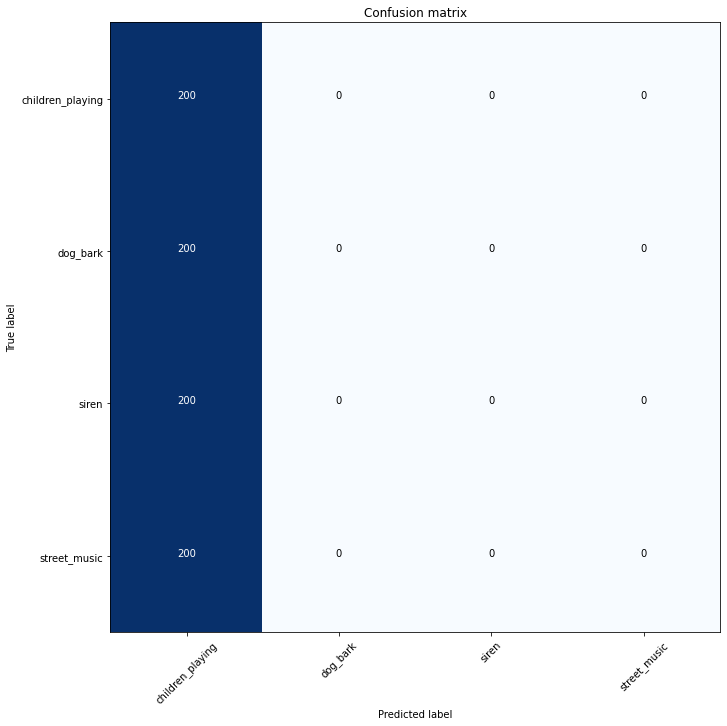

In [ ]:
# get predictions and labels as arrays
y_test_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_prob, axis=1)
# y_test_true = np.argmax(np.array([y for x, y in test_dataset.unbatch().as_numpy_iterator()]), axis=1)
y_test_true = np.argmax(y_test, axis=1)

# call confusion matrix
cm = tf.math.confusion_matrix(labels=y_test_true, predictions=y_test_pred)
cm = cm.numpy()
plot_confusion_matrix(cm, classes=config['classes'], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

---

## 7. Predict on real data

We have now trained and evaluated our model and can use it to predict new audiofiles from "real-life". Let's load an unseen audiofile and see how the model performs:

In [ ]:
# get real-life audio-file
file_path = '_audio/lisboa_siren.wav'
pd.display(pd.Audio(file_path))
audio = load_audio(file_path)

In [ ]:
# we need to convert audio to exact input format to neural network (mel_spec of 1s audio)
audio_frames  = tf.signal.frame(signal=audio,
                                frame_length=1*config['sr'],
                                frame_step=1*config['sr'],
                                pad_end=True)

print(f'Real life audio in frames, shape: {audio_frames.shape}')

# get melspecs an 
X_real = []
for audio_frame in audio_frames:
    mel_spec = convert_audio_to_melspectrogram(audio_frame.numpy())
    X_real.append(mel_spec)

# convert to array
X_real = np.array(X_real)
print(f'Real life mel_specs, shape: {X_real.shape}')

Real life audio in frames, shape: (7, 16000)
Real life mel_specs, shape: (7, 64, 63, 1)


In [ ]:
# get predictions and labels as arrays
y_real_prob = model.predict(X_real)
y_real_pred = np.argmax(y_real_prob, axis=1)

print(classes)
print(y_real_prob)
print(y_real_pred)


['children_playing', 'dog_bark', 'siren', 'street_music']
[[0.32174438 0.6505619  0.52788216 0.6912627 ]
 [0.30906752 0.6646381  0.5249933  0.706135  ]
 [0.30828163 0.6652985  0.524796   0.7070768 ]
 [0.3091413  0.66476697 0.52516603 0.7062743 ]
 [0.30824733 0.6658645  0.5248402  0.7075116 ]
 [0.3118443  0.6623375  0.525732   0.7035082 ]
 [0.3230844  0.64911026 0.52841526 0.68950856]]
[3 3 3 3 3 3 3]


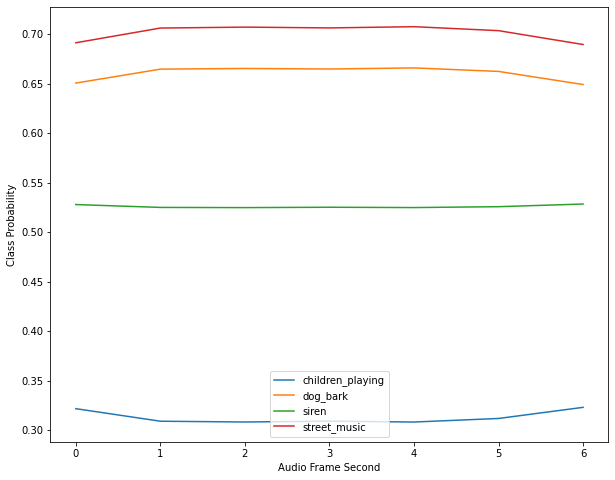

In [ ]:
# plot predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(y_real_prob)
ax.legend(classes)
ax.set_ylabel('Class Probability')
ax.set_xlabel('Audio Frame Second')
plt.show()

---

---

# END

---

---

## Further reading and resources:

#### UrbanSound8k dataset:  
https://urbansounddataset.weebly.com/urbansound8k.html

#### Tensorflow audio tutorials:
https://www.tensorflow.org/tutorials/audio/simple_audio

#### Coursera Machine/Deep Learning Courses:
https://www.coursera.org/learn/machine-learning  
https://www.coursera.org/specializations/deep-learning

#### Deep Learning for Audio Event Detection (TU Berlin):
https://www.ak.tu-berlin.de/menue/lehre/vergangene_semester/wintersemester_202021/deep_learning_for_audio_event_detection_dl4aed/

---